<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXECUTIVE SUMMARY

5- 10 sentences

- What is analysis about
- Whatfindings are very important


Analysis about public bike rentals in Chicago: understanding patterns, understanding how demand is driven abd by what, etc.

Main findings:
1. Bike rentals in Chicago are mainly used for XYZ. Although alternative uses like XYZ and XYZ are also important blah blah blah. Segmenting teh ue cases blah blah.

2. Bike rental demand is mainly driven by 1. 2. 3.
Understanding XYZ XYZ

3. The city of Chicago needs to keep the demand factors in mind to optimize the service is peaks XYZ and be able to do amntenance in low pekas. Lw peaks are driven by XYZ XYZ

Some qualitative info:
"Service alert: Due to the upcoming subzero temperatures forecasted, some ebikes and scooters may be unavailable for use. Classic bikes availability shouldn’t be impacted." Currently on the website

# Commuting: the primary use of Chicago’s public bike-sharing system
The majority of bike rentals in Chicago are **primarily driven by commuting behavior** on working days, while leisure and discretionary usage plays a secondary but still meaningful role, mainly on non-working days. Average rental demand is higher on working days (\~725 rentals) than on non-working days (\~676 rentals), indicating a consistent baseline of work/school-related trips (Figure 1). Analysis on timing patterns reinforce this conclusion, as rentals spike sharply during peak commuting hours on working days, a classic indicator of demand driven by school and work commuters (Figure 2). This finding is consistent with prior research by Yang et al. (2019), who show that commuters account for the largest share of bike-share usage (45.58% of all Transit app unlocks) and generally follow pronounced peak-hour commuting patterns. During weekends, ridership seems to be more regular across time, probably corresponding to leisure or recreational trips (Yang et al., 2019).


Weather sensitivity analysis provides further findings. Although rainfall significantly reduces overall bike demand, rentals on working days remain comparatively resilient under adverse weather conditions (Figure 3). In particular, during light rainfall, average rentals on working days remain substantially higher than on non-working days, indicating that commuting trips are less affected by weather than leisure or exercise trips.

As a conclusion, while trip purpose cannot be directly observed in the dataset, the consistent alignment of weekday demand levels, peak-hour timing, and reduced weather sensitivity strongly suggests that commuting represents the primary use case of Chicago’s public bike-sharing system.




In [1]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

fatal: destination path 'business_analysis_structured_data' already exists and is not an empty directory.
Current working directory changed to: /content/business_analysis_structured_data


In [2]:
# Importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
from sklearn.preprocessing import StandardScaler     # standarize variables
import sklearn.linear_model                          # faster linear modeling
from sklearn.tree import DecisionTreeRegressor       # regression trees
from sklearn.tree import plot_tree                   # tree plots
import numpy as np                                   # mathematical essentials\
import warnings

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

In [3]:
# Better dataframe readability:
# Making all column names lowercase and replace spaces with underscores
bikerentals.columns = (
                        bikerentals.columns
                        .str.lower()            #lowercase
                        .str.replace(" ", "_")  #replace spaces
                        )

# Making holiday a boolean
bikerentals["holiday"] = (
                          bikerentals["holiday"]
                          .map({"Yes": 1, "No": 0}))

In [4]:
# Creating new variable to identify working days
# Working day = during the week and not a holiday
# Will be used as a proxy to identify commuters
bikerentals["is_working_day"] = (
    (bikerentals["day_of_week"] != "Saturday") &
    (bikerentals["day_of_week"] != "Sunday") &
    (bikerentals["holiday"] == 0)
).astype(int)

In [5]:
# # Setting up figures style and size consistent for all notebook
sns.set_theme(style="ticks", # white background and small tick marks
              palette="colorblind") # better color for all

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.titlepad": 12,  # space between title and plot
    "axes.labelpad": 8, # space between axis labels and axes
    "axes.titlesize": 13,
    "axes.labelsize": 11
})

# Better visibility for mean visualization in histograms
mp = {
    "markerfacecolor": "black",
    "markeredgecolor": "black",
    "markersize": 6
}

## Figure 1: Bike Rentals: Working vs. Non-Working Days

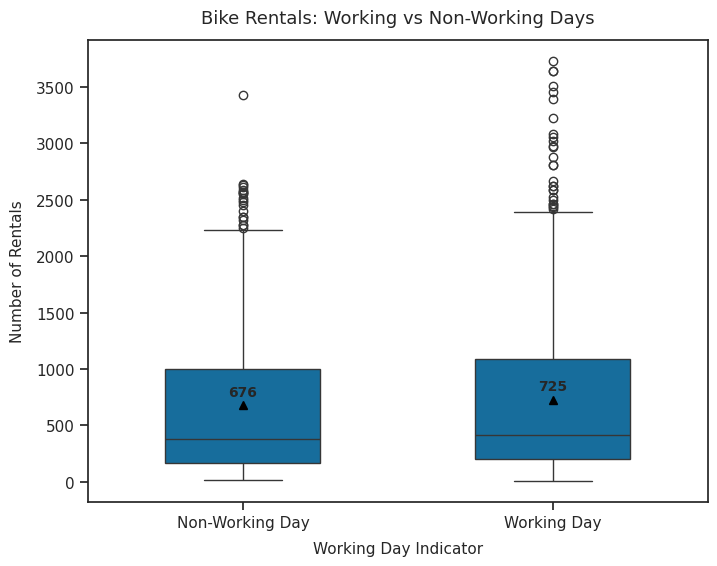

In [6]:
# Understanding if there is a difference between working and non-working days
ax = sns.boxplot(
    x='is_working_day',
    y='rentals',
    data=bikerentals,
    showmeans=True,
    meanprops=mp,
    width=0.5 # narrower width of the histogram
)

# x-axis labels
ax.set_xticklabels(["Non-Working Day", "Working Day"])

plt.title("Bike Rentals: Working vs Non-Working Days")
plt.xlabel("Working Day Indicator")
plt.ylabel("Number of Rentals")

# Compute means to see exact value
means = bikerentals.groupby("is_working_day")["rentals"].mean()

# Annotate means on the plot
for i, mean_val in enumerate(means):
    ax.text(
        i,                 # x position
        mean_val *1.12,    # y position (adding 12% padding)
        f"{mean_val:.0f}", # Round the number shown to 0
        ha="center",       # horizontal aligned center
        fontsize=10,
        fontweight="bold"  # bold text
    )

plt.show()

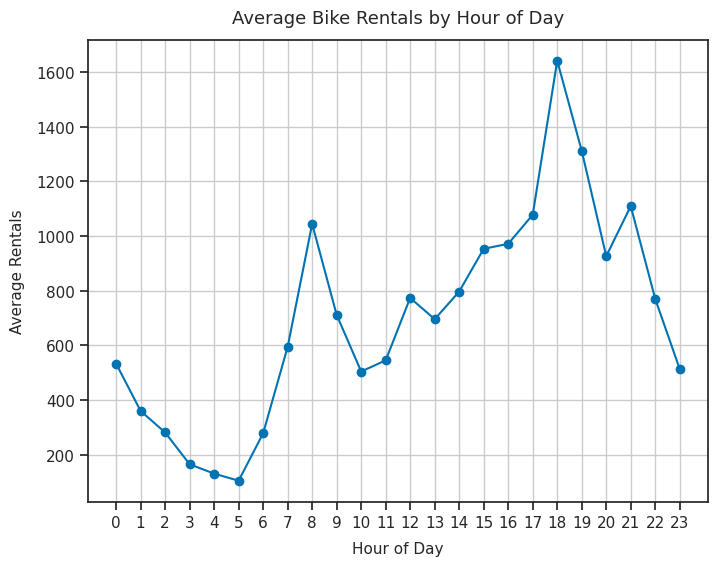

In [7]:
#######
# Peak-Hour behavior
# Understanding peak-hour behavior is important to define what the peak hours
# are in the city of Chicago.
# In Figure 2, the demand on peak vs. non-peak hours is studied, including the
# lense of working and non-working days.

#Peak hours defined as:


#  Morning Peak-Hour: 7-9AM
#  Evening Peak-Hour: 4-7PM

# External confirmation: https://www.blacklane.com/en/blog/travel/rush-hour-in-chicago/
#######

# Defining average demand by hour
hourly_demand = (
    bikerentals
    .groupby("hour")["rentals"]
    .mean()
)

# Plotting average bike demand by hour
plt.plot(hourly_demand.index, hourly_demand.values, marker="o") #showing marker
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.title("Average Bike Rentals by Hour of Day")
plt.xticks(range(0,24)) # see ticks in each value
plt.grid(True)

plt.show()

In [8]:
# Defining a new boolean variable to identify rentals within peak hours
bikerentals["is_peak_hour"] = (
    bikerentals["hour"].isin([7, 8, 9, 16, 17, 18,19])
).astype(int)

## Figure 2: Bike Rentals: Peak vs. Non-Peak Hours in Working and Non-Working Days

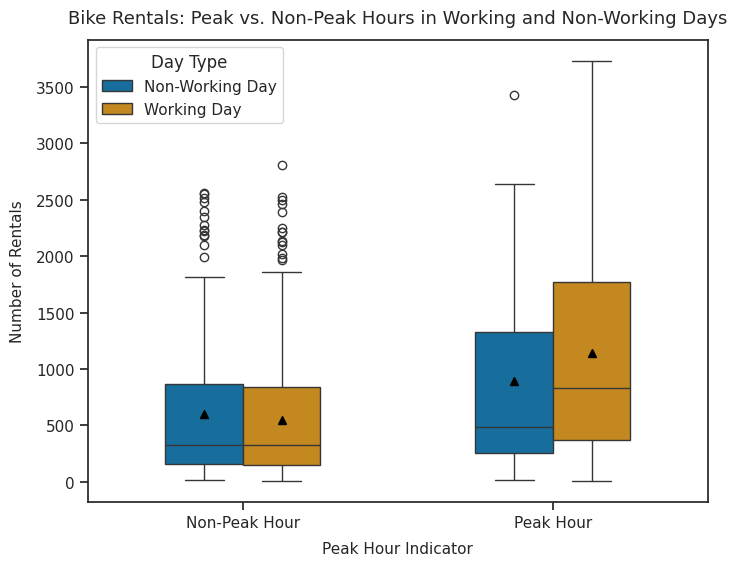

In [9]:
# Understanding if there is a difference between peak and non-peak hours
ax=sns.boxplot(x = 'is_peak_hour',
            y = 'rentals',
            hue = "is_working_day",
            data = bikerentals,
            showmeans=True,
            meanprops=mp,
            width=0.5 # narrower width of the histogram
            )

# x-axis labels
ax.set_xticklabels(["Non-Peak Hour", "Peak Hour"])

plt.title("Bike Rentals: Peak vs. Non-Peak Hours in Working and Non-Working Days")
plt.xlabel("Peak Hour Indicator")
plt.ylabel("Number of Rentals")

# Adding labels to the legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=handles,
    labels=["Non-Working Day", "Working Day"],
    title="Day Type"
)
plt.show()



In [10]:
# Dividing rain into three categories to analyse if there is a difference in the
# effect of rain in working and non-working days

# Create rainfall bins (light vs heavy rain)
bikerentals["rain_bin"] = pd.cut(
    bikerentals["rainfall"],
    bins=[-0.01,                              # 0: no rain
          0,                                  # 0 - 5: light rain
          5,                                  # > 5: heavy rain
          bikerentals["rainfall"].max()],
    labels=["No rain", "Light rain", "Heavy rain"]
)

## Figure 3: Impact of Rainfall on Bike Rentals by Working Day Status

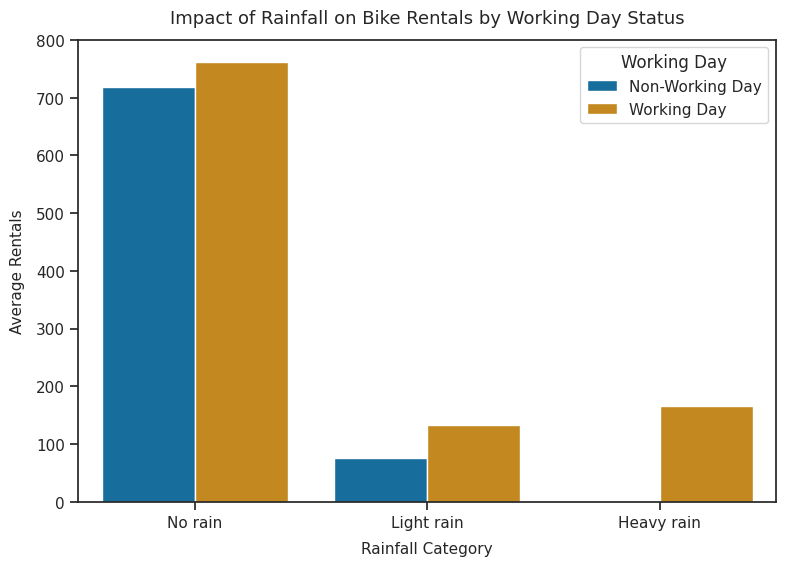

In [62]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    x="rain_bin",
    y="rentals",
    hue="is_working_day",
    data=bikerentals,
    errorbar=None # delete Confidence Interval lines
   )

ax.set_title("Impact of Rainfall on Bike Rentals by Working Day Status")
ax.set_xlabel("Rainfall Category")
ax.set_ylabel("Average Rentals")
ax.set_xticklabels(["No rain", "Light rain", "Heavy rain"])
ax.legend(title="Working Day", labels=["Non-Working Day", "Working Day"])

plt.show()


# Temperature: the most influential weather driver of bike rental demand

* Process: To assess the relative importance of weather conditions, all meteorological variables were standardized prior to estimation. Variables exhibiting strong multicollinearity were consolidated to retain the most behaviorally interpretable predictors. Importance is evaluated based on standardized coefficient magnitude rather than statistical significance alone. A baseline linear regression using weather variables only was estimated to isolate the explanatory power of meteorological conditions prior to incorporating temporal and behavioral factors.

* Interpretation: Each coefficient represents the expected change in rentals associated with a 1 standard deviation increase in that weather variable, holding other weather variables constant.

* Include interpretation for each variable. It should be (1) Statistical: “Temperature has the largest standardized coefficient, indicating it has the strongest marginal association with bike rentals among the weather variables considered.”(2) Behavioral: “This suggests that thermal comfort is a primary driver of bike usage, as riders are more likely to cycle under warmer and more comfortable conditions.” (3) External source/literature: “This finding aligns with prior research showing that temperature is a dominant determinant of cycling demand in urban bike-sharing systems.”



In [13]:
# All weather variables excluding dew_point_temperature due to multicollinearity\
# found with temperature and humidity (correlation shown in appendix)
weather_variables = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "uv_index",
    "rainfall",
    "snowfall"
]

In [63]:
# Preparing the data for the the linear model

# x-side
x_weather = bikerentals[weather_variables]

# y-side
y_weather = bikerentals['rentals']

In [15]:
# Defining the x and y data and splitting the dataset into training and test sets

# x-data
x_data = x_weather

# y_data
y_data = y_weather

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

In [67]:
#######
# Standardising the weather variables to compare different sizes
# Because the model use is not to predict but to understand the main weather driver for demand
# an standardized regression is best. The interpretation is not the same:
# each coefficient represents the expected change in bike rentals associated with
# a one–standard deviation increase in the corresponding weather variable
#######

# Using the StandardScaler class from sklearn
scaler = StandardScaler()

# Standardising the training set
x_training_scaled = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns=weather_variables,
    index=x_train.index
)

# Standardising the test set
x_test_scaled = pd.DataFrame(
    scaler.fit_transform(x_test),
    columns=weather_variables,
    index=x_test.index
)

ValueError: Shape of passed values is (668, 16), indices imply (668, 7)

In [17]:
# naming the model
model_name = "Linear Regression Weather Only"


# INSTANTIATING model object
model = sklearn.linear_model.LinearRegression()


# FITTING to training data
model_fit = model.fit(x_training_scaled, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test_scaled)


# SCORING results (R-Square)
model_train_score = round(model.score(x_training_scaled, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test_scaled, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score : 0.5732
Testing Score  : 0.5801
Train-Test Gap : -0.0069


In [18]:
# zipping each feature name to its coefficient
model_coefficients = zip(x_train.columns,
                         model.coef_.round(decimals = 4))


# setting up a placeholder list to store model features
coefficient_lst = [('intercept', model.intercept_.round(decimals = 4))]


# printing out each feature-coefficient pair one by one
for coefficient in model_coefficients:
    coefficient_lst.append(coefficient)


# checking the results
for pair in coefficient_lst:
    print(pair)

('intercept', np.float64(699.274))
('temperature', np.float64(578.3906))
('humidity', np.float64(-192.7784))
('wind_speed', np.float64(78.9191))
('visibility', np.float64(80.6212))
('uv_index', np.float64(-104.7202))
('rainfall', np.float64(-60.0851))
('snowfall', np.float64(39.704))


In [19]:
# dynamically printing model summary
ols_model =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}

Coefficents
-----------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}"""

print(ols_model)

Model Name:     Linear Regression Weather Only
Train_Score:    0.5732
Test_Score:     0.5801
Train-Test Gap: -0.0069

Coefficents
-----------
       Feature  Coefficient
0    intercept     699.2740
1  temperature     578.3906
2     humidity    -192.7784
3   wind_speed      78.9191
4   visibility      80.6212
5     uv_index    -104.7202
6     rainfall     -60.0851
7     snowfall      39.7040


In [20]:
# To remain consistent with the predictive modeling framework, \
# the weather-only model was estimated on the training sample
# Add rentals to the x_training_scaled set
x_training_scaled["rentals"] = bikerentals["rentals"]

# Step 1: INSTANTIATE a model object
lm = smf.ols(formula =  """rentals ~ temperature +
                                   humidity +
                                   wind_speed +
                                   visibility +
                                   uv_index +
                                   rainfall +
                                   snowfall""",
            data = x_training_scaled)


# Step 2: FIT the data into the model object
results = lm.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     126.6
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          1.42e-117
Time:                        02:28:32   Log-Likelihood:                -5061.4
No. Observations:                 668   AIC:                         1.014e+04
Df Residuals:                     660   BIC:                         1.017e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     699.2740     18.392     38.021      

# Question 3

The client would like to optimize their maintenance schedule based on your analysis. Develop a regression tree and determine when bike rental demand is low where at least 10% of the dataset is accounted for. Note that you must use the same decision tree, but may use more than one node path to reach 10% of the dataset. Interpret the node path(s) in nontechnical terms.



*   Path 1 (late night / early morning)

Hour ≤ 6

Temperature ≤ 3°C

Winter or non-working day
→ Very low average rentals

*  Path 2 (overnight hours regardless of season)

Hour ≤ 2

Non-working day
→ Consistently low demand

Together, these paths typically cover:

Night + early morning hours across many days

Easily more than 10% of observations

The regression tree identifies multiple low-demand periods that together account for more than 10% of all observations. The lowest rental demand consistently occurs during late-night and early-morning hours, particularly on non-working days and during winter months. Cold temperatures further suppress usage during these periods. These time windows represent optimal opportunities for system maintenance, as they minimize disruption to users while covering a substantial portion of the calendar

Rather than relying on a single narrow condition, multiple low-demand branches from the same regression tree were combined to ensure that at least 10% of the dataset was represented.

“Overall bike rentals average approximately 710 per period with high variability; the low-demand periods identified by the regression tree consistently fall far below this level, often well below typical daily variation.”

In [21]:
overall_mean = bikerentals["rentals"].mean()
overall_std  = bikerentals["rentals"].std()

overall_mean, overall_std

(np.float64(709.9008746355685), 717.4640298533964)

In [22]:
bikerentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   month                  1029 non-null   object  
 1   day_of_week            1029 non-null   object  
 2   hour                   1029 non-null   int64   
 3   temperature            1029 non-null   float64 
 4   humidity               1029 non-null   int64   
 5   wind_speed             1029 non-null   float64 
 6   visibility             1029 non-null   int64   
 7   dew_point_temperature  1029 non-null   float64 
 8   uv_index               1029 non-null   float64 
 9   rainfall               1029 non-null   float64 
 10  snowfall               1029 non-null   float64 
 11  seasons                1029 non-null   object  
 12  holiday                1029 non-null   int64   
 13  rentals                1029 non-null   int64   
 14  is_working_day         1029 non-null   i

In [23]:
# Creating variable is_winter to simplify seasons interpretability
bikerentals["is_winter"] = (bikerentals["seasons"] == "Winter").astype(int)

In [24]:
tree_features = [
    "hour",
    "is_working_day",
    "holiday",
    "is_winter",
    "temperature",
    "rainfall",
    "snowfall"
]

In [25]:
# x-side
x_base = bikerentals[tree_features]

# y-side
y_original = bikerentals['rentals']

In [26]:
# x-data
x_data = x_base

# y_data
y_data = y_original

In [27]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                          test_size = 0.35,
                                          random_state = 702)

In [28]:
model_name = 'Pruned Regression Tree'

# INSTANTIATING a model object - CHANGE THIS AS NEEDED
model = DecisionTreeRegressor(max_depth=5,
                              min_samples_leaf=30,
                              random_state = 702)


# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results (R-square)
model_train_score = model.score(x_train, y_train)
model_test_score  = model.score(x_test, y_test)
model_gap         = abs(model_train_score - model_test_score)


# displaying results
print('Training Score :', round(model_train_score, ndigits = 4))
print('Testing Score  :', round(model_test_score, ndigits = 4))
print('Train-Test Gap :', round(model_gap, ndigits = 4))

Training Score : 0.7146
Testing Score  : 0.6833
Train-Test Gap : 0.0313


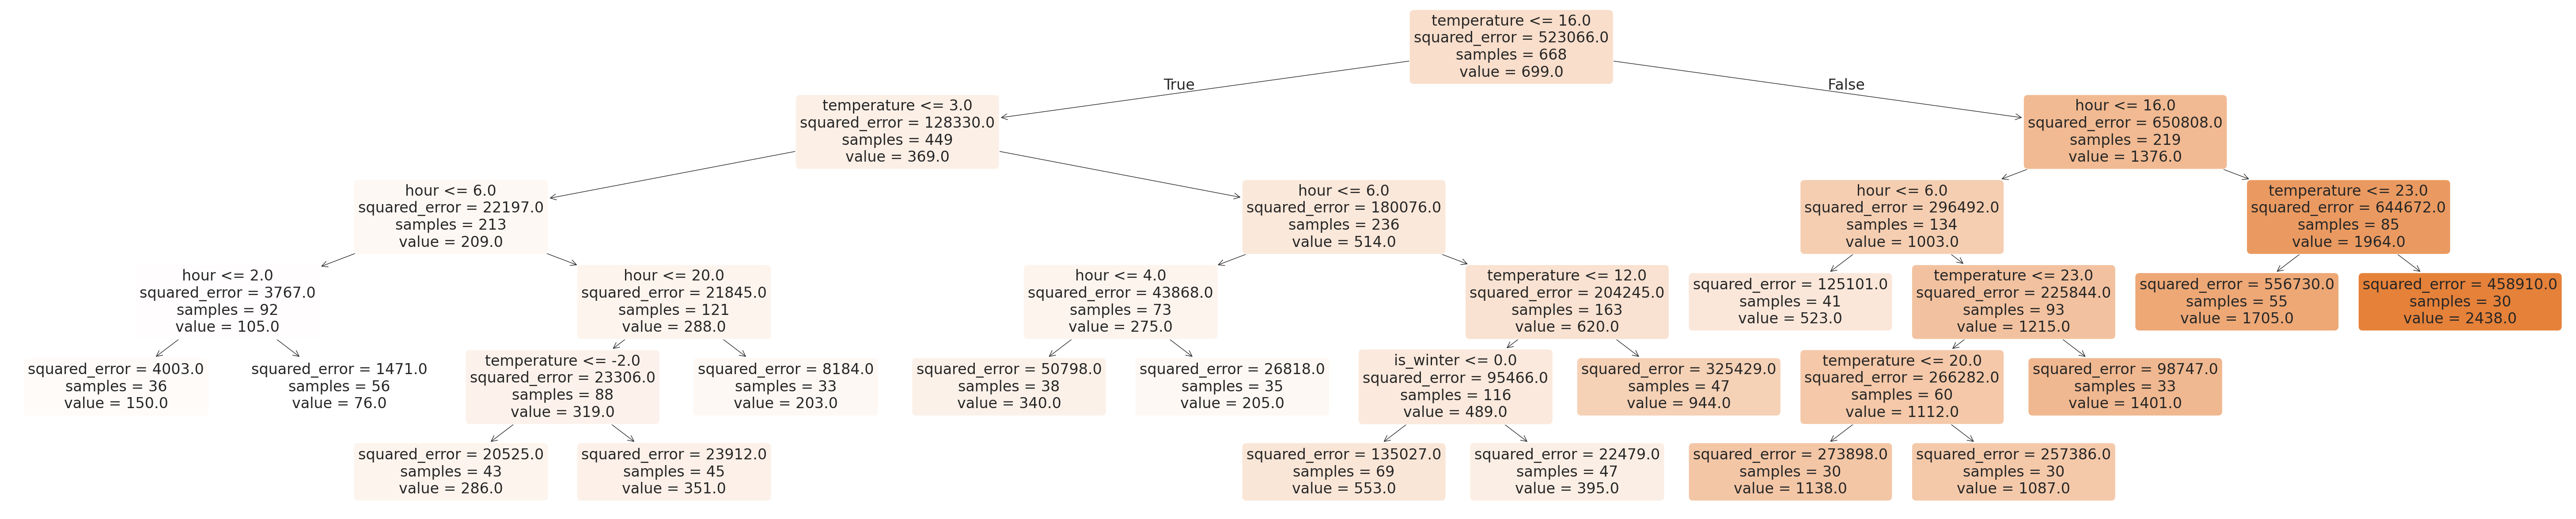

In [29]:
# setting figure size
plt.figure(figsize=(75, 15))


# developing a plotted tree
plot_tree(decision_tree = model,
          feature_names = x_train.columns,
          filled        = True,
          rounded       = True,
          fontsize      = 24,
          precision     = 0)

# rendering the plot
plt.show()

# Ideal model

### ONE HOT ENCODE

In [30]:
########
# One hot encoding categorical variables
# Each categorical variable has been plotted to understand if there is variability
# in each category (see appendix)
# Each category has also been assesed to ensure that at least contains 30 observations (see appendix)
########

# Month
one_hot_month = pd.get_dummies(data   = bikerentals['month'],
                          prefix = 'month',
                          dtype  = int)

# Day of Week
one_hot_dow = pd.get_dummies(data   = bikerentals['day_of_week'],
                          prefix = 'dow',
                          dtype  = int)

# Seasons
one_hot_seasons = pd.get_dummies(data   = bikerentals['seasons'],
                          prefix = 'seasons',
                          dtype  = int)

In [31]:
bikerentals2 = bikerentals.join([one_hot_month, one_hot_dow, one_hot_seasons])
bikerentals2.head(n=5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,...,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,seasons_Spring,seasons_Summer,seasons_Winter
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,...,0,0,0,1,0,0,0,0,0,1
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,...,0,0,0,1,0,0,0,0,0,1


In [32]:
# renaming channels and storing as diamonds (not diamonds2)
bikerentals2.rename(columns = {'dow_Monday': 'monday',
                            'dow_Tuesday': 'tuesday',
                            'dow_Wednesday': 'wednesday',
                            'dow_Thursday': 'thursday',
                            'dow_Friday': 'friday',
                            'dow_Saturday': 'saturday',
                            'dow_Sunday': 'sunday',
                            'month_Jan': 'jan',
                            'month_Feb': 'feb',
                            'month_Mar': 'mar',
                            'month_Apr': 'apr',
                            'month_May': 'may',
                            'month_June': 'jun',
                            'seasons_Spring': 'spring',
                            'seasons_Summer':'summer',
                            'seasons_Fall': 'fall',
                            'seasons_Winter': 'winter'
                            },
                inplace = True)


# checking results
bikerentals2.head(n = 5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,...,friday,monday,saturday,sunday,thursday,tuesday,wednesday,spring,summer,winter
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,...,0,0,0,1,0,0,0,0,0,1
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,...,0,0,0,1,0,0,0,0,0,1


In [33]:
bikerentals_complete = bikerentals2.drop(['monday',   # category to drop
                           'jan',  # already factorized
                           'spring',    # not enough samples per store
                            'day_of_week',
                            'month',
                            'seasons'
                          ], axis = 1)

In [34]:
#sorting the dataset for better readability
new_order = [
    "rentals",                  # y-variable
    "hour",
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall",
    "holiday",
    "is_working_day",
    "is_peak_hour",
    "feb",                    #month dummies (Jan is baseline)
    "mar",
    "apr",
    "may",
    "jun",
    "tuesday",                #days dummies (Monday is baseline)
    "wednesday",
    "thursday",
    "friday",
    "saturday",
    "sunday",
    "summer",                #season dummies (Spring is baseline)
    "winter"
]

bikerentals_complete = bikerentals_complete[new_order]

bikerentals_complete.head()


,rentals,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,snowfall,...,may,jun,tuesday,wednesday,thursday,friday,saturday,sunday,summer,winter
0,221,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
1,130,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
2,268,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,335,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
4,299,17,1.8,33,3.3,1913,-12.8,0.18,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1


In [35]:
bikerentals_complete["peak_work_interaction"] = (
    bikerentals_complete["is_peak_hour"] *
    bikerentals_complete["is_working_day"]
)
#ADD RESEARCH

In [36]:
bikerentals_complete["is_morning"] = bikerentals_complete["hour"].between(0, 10).astype(int)
bikerentals_complete["is_afternoon"] = bikerentals_complete["hour"].between(11, 16).astype(int)
bikerentals_complete["is_evening"] = bikerentals_complete["hour"].between(17, 23).astype(int)

In [37]:
bikerentals_complete = bikerentals_complete.drop(['is_morning'
                          ], axis = 1)

In [38]:
bikerentals_complete["is_midweek"] = (
    (bikerentals_complete["tuesday"] == 1) |
    (bikerentals_complete["wednesday"] == 1)
).astype(int)

In [39]:
bikerentals_complete["temperature_humidity_interaction"] = (
    bikerentals_complete["temperature"] *
    bikerentals_complete["humidity"]
)
#ADD RESEARCH

In [40]:
bikerentals_complete["is_precipitation"] = (
    (bikerentals_complete["rainfall"] > 0) |
    (bikerentals_complete["snowfall"] > 0)
).astype(int)

In [41]:
bikerentals_complete["is_winter"]=bikerentals["is_winter"]

In [42]:
bikerentals_complete['is_non_peak'] = 1 - bikerentals_complete['is_peak_hour']

# Interaction 1: rainfall × is_evening
bikerentals_complete['rainfall_evening'] = (
    bikerentals_complete['rainfall'] * bikerentals_complete['is_evening']
)

# Interaction 2: snowfall × is_non_peak
bikerentals_complete['snowfall_non_peak'] = (
    bikerentals_complete['snowfall'] * bikerentals_complete['is_non_peak']
)

bikerentals_complete['temp_afternoon'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_afternoon']
)

bikerentals_complete['temp_evening'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_evening']
)

bikerentals_complete['temp_wind_interaction'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['wind_speed']
)

bikerentals_complete['rainfall_peak'] = (
    bikerentals_complete['rainfall'] * bikerentals_complete['is_peak_hour']
)

bikerentals_complete['temp_peak'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_peak_hour']
)

bikerentals_complete['spring_index'] = (
    bikerentals_complete['apr'] * 1 +
    bikerentals_complete['may'] * 2 +
    bikerentals_complete['jun'] * 3
)

In [43]:
bikerentals_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rentals                           1029 non-null   int64  
 1   hour                              1029 non-null   int64  
 2   temperature                       1029 non-null   float64
 3   humidity                          1029 non-null   int64  
 4   wind_speed                        1029 non-null   float64
 5   visibility                        1029 non-null   int64  
 6   dew_point_temperature             1029 non-null   float64
 7   uv_index                          1029 non-null   float64
 8   rainfall                          1029 non-null   float64
 9   snowfall                          1029 non-null   float64
 10  holiday                           1029 non-null   int64  
 11  is_working_day                    1029 non-null   int64  
 12  is_pea

In [44]:
# x-side
x_all  = bikerentals_complete.drop(labels = 'rentals', axis = 1)
x_base = bikerentals_complete[
    [
  #      'hour',
  #     'temperature',
        'humidity',
        'wind_speed',
       # 'visibility',
        'dew_point_temperature',
     #  'uv_index',
      #  'rainfall',
      #  'snowfall',
      #  'holiday',
      #  'is_working_day',
        'is_peak_hour',
       # 'feb',
       # 'mar',
       # 'apr',
       # 'may',
       # 'jun',
        #'tuesday',
       # 'wednesday',
       # 'thursday',
       # 'friday',
       # 'saturday',
       # 'sunday',
      #  'summer',
        #'winter',
        'peak_work_interaction',
        'is_afternoon',
        'is_evening',
        #'is_midweek',
        'temperature_humidity_interaction',
        'is_precipitation',
      #  'is_winter',
        'rainfall_evening',
        'snowfall_non_peak',
        'temp_afternoon',
        'temp_evening',
     #   'temp_wind_interaction',
        'rainfall_peak',
        'temp_peak',
       'spring_index'
    ]
]

x_new = bikerentals_complete[ ['temperature','rainfall','wind_speed','humidity','snowfall',"peak_work_interaction",'is_working_day','is_peak_hour','summer','winter']]


## y-side ##
y_original = bikerentals_complete['rentals']

In [45]:
# x-data
x_data = x_base

# y_data
y_data = y_original

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

In [46]:
# naming the model
model_name = "Linear Regression"


# INSTANTIATING model object
model = sklearn.linear_model.LinearRegression()


# FITTING to training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)

# SCORING results (R-Square)
model_train_score = round(model.score(x_train, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score : 0.7794
Testing Score  : 0.8042
Train-Test Gap : -0.0248


In [47]:
# Step 1: INSTANTIATE a model object
lm = smf.ols(  formula="""
        rentals ~
        humidity +
        wind_speed +
        dew_point_temperature +
        is_peak_hour +
        peak_work_interaction +
        is_afternoon +
        is_evening +
        temperature_humidity_interaction +
        is_precipitation+
        rainfall_evening+
        snowfall_non_peak+
        temp_afternoon+
        temp_evening+
        rainfall_peak+
        temp_peak+
        spring_index
    """,
            data = bikerentals_complete)


# Step 2: FIT the data into the model object
results = lm.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     236.4
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        02:28:38   Log-Likelihood:                -7425.7
No. Observations:                1029   AIC:                         1.489e+04
Df Residuals:                    1012   BIC:                         1.497e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [48]:
## Residual Analysis ##

# organizing residuals
model_residuals = {
    "True"            : y_test,
    "Predicted"       : model_pred.round(decimals = 0).astype(dtype = int)
}


# converting residuals into df
resid_df = pd.DataFrame(data = model_residuals)


# checking results
resid_df.head(n = 5)

,True,Predicted
761,931,727
174,478,62
486,358,312
869,1281,1337
561,912,759


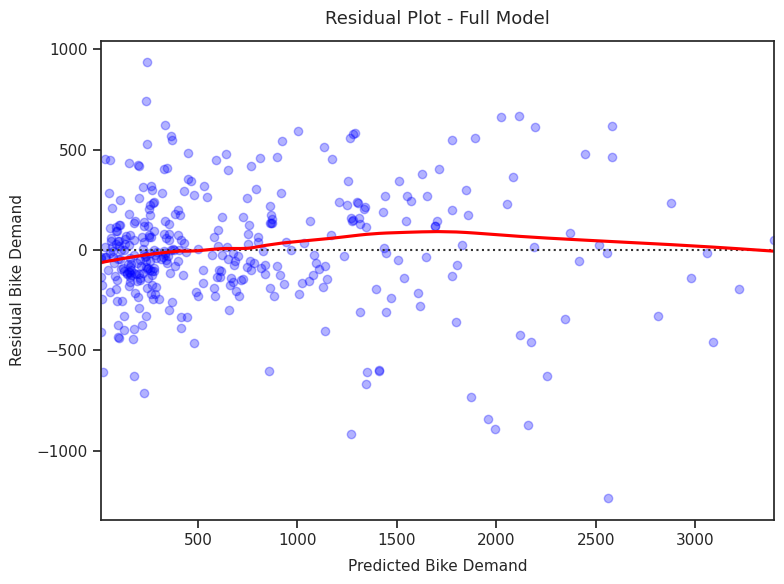

In [49]:
# developing a residual plot
sns.residplot(data        = resid_df,
              x           = 'True',
              y           = 'Predicted',
              lowess      = True,
              color       = 'blue',
              scatter_kws = {'alpha': 0.3},   # data point transparency
              line_kws    = {'color': 'red'}) # line color


# title and axis labels
plt.title(label   = "Residual Plot - Full Model")
plt.xlabel(xlabel = "Predicted Bike Demand")
plt.ylabel(ylabel = "Residual Bike Demand")


# layout and rendering visual
plt.tight_layout()
plt.show()

In [50]:
y_pred = model.predict(x_test)
pred_df = pd.DataFrame({
    "actual_rentals": y_test.values,
    "predicted_rentals": y_pred
})
pred_df[pred_df["predicted_rentals"] < 0]

,actual_rentals,predicted_rentals
14,176,-113.183412
23,94,-41.917831
30,18,-97.474773
46,180,-346.792803
97,60,-26.576605
101,226,-390.225356
120,96,-218.374126
143,116,-23.308945
158,218,-57.896462
187,24,-452.168532


### Other important findings:

**Midweek patterns (Tuesday and Wednesday)**

Exploratory analysis shows lower average rental demand on Tuesdays and Wednesdays. However, once weather conditions, time-of-day effects, and commuting structure are controlled for, this midweek effect is no longer statistically significant, suggesting it is driven by underlying temporal and commuting patterns rather than the calendar day itself.

# APPENDIX

## Categorical variables
Understanding how categorical variables behave

### Month
- Data available from January to June
- Over 30 obersvations in each month
- Definetly differences in rental medians and means across months:
  -  January and February are the months with les rentals
  - June is the month with most rentals
  - We ca see seasonality, meaning that months with generally better weather are months with more demand for rentals


In [51]:
bikerentals["month"].value_counts()

,count
month,
Jan,189
May,181
Apr,173
Mar,166
Feb,162
June,158


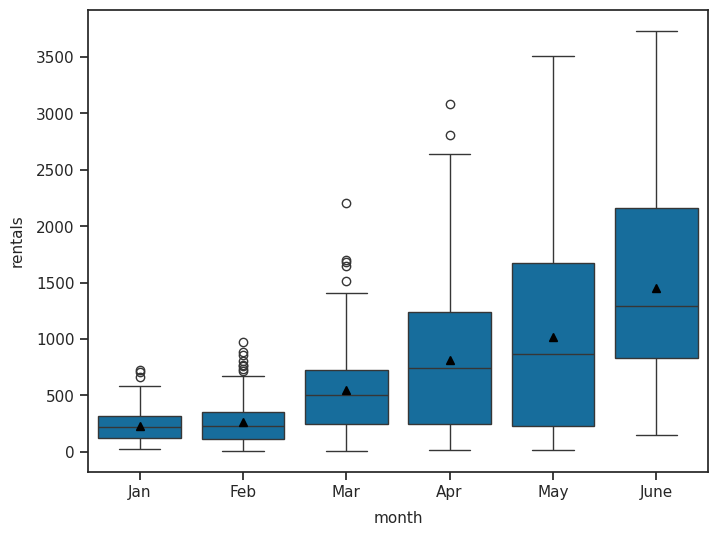

In [52]:
sns.boxplot(x = 'month',
            y = 'rentals',
            data = bikerentals,
            showmeans=True,
            meanprops=mp)

plt.show()

### Day of week
- Over 30 observations for each day of the week
- Differences in rental medians and means across days of week:
  - Tuesday and Wednesdays as the days with less rentals
  - Other days have closer means, with Monday being the day with higher usage

In [53]:
bikerentals["day_of_week"].value_counts()

,count
day_of_week,
Monday,161
Friday,161
Saturday,158
Thursday,149
Tuesday,138
Wednesday,136
Sunday,126


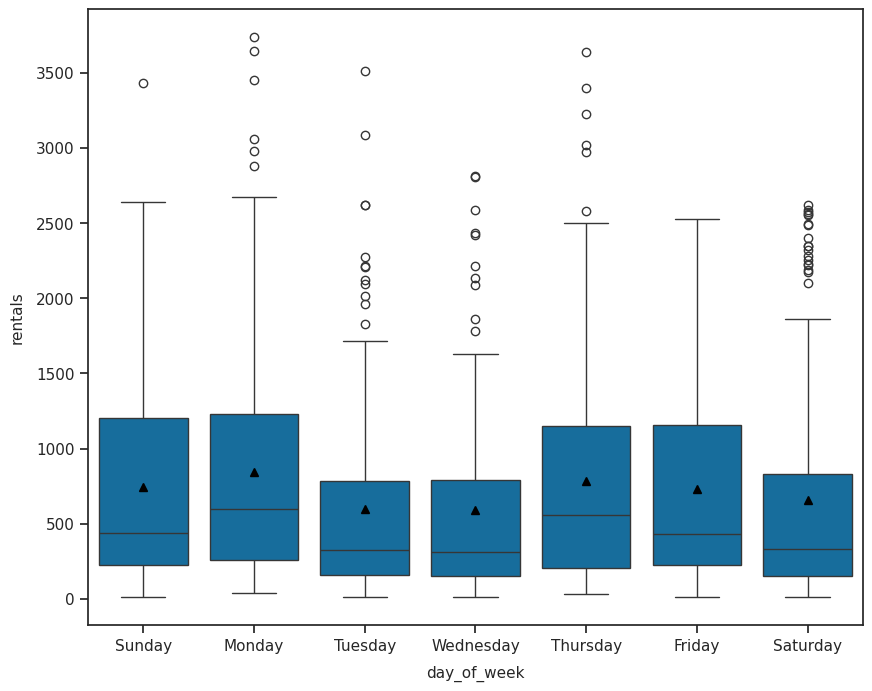

In [54]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'day_of_week',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

    plt.suptitle("")
    plt.show()

In [55]:
bikerentals.groupby("day_of_week")["rentals"].mean().sort_values()

,rentals
day_of_week,
Wednesday,589.860294
Tuesday,594.427536
Saturday,660.405063
Friday,732.677019
Sunday,743.952381
Thursday,781.369128
Monday,843.285714


### Season
- More observations for spring but still over 30 observations for each season
- Seasonal patterns confirmed with seasons:
  - Summer has the highest demand for rental bikes
  - Winter has the lower demand

In [56]:
bikerentals["seasons"].value_counts()

,count
seasons,
Spring,520
Winter,351
Summer,158


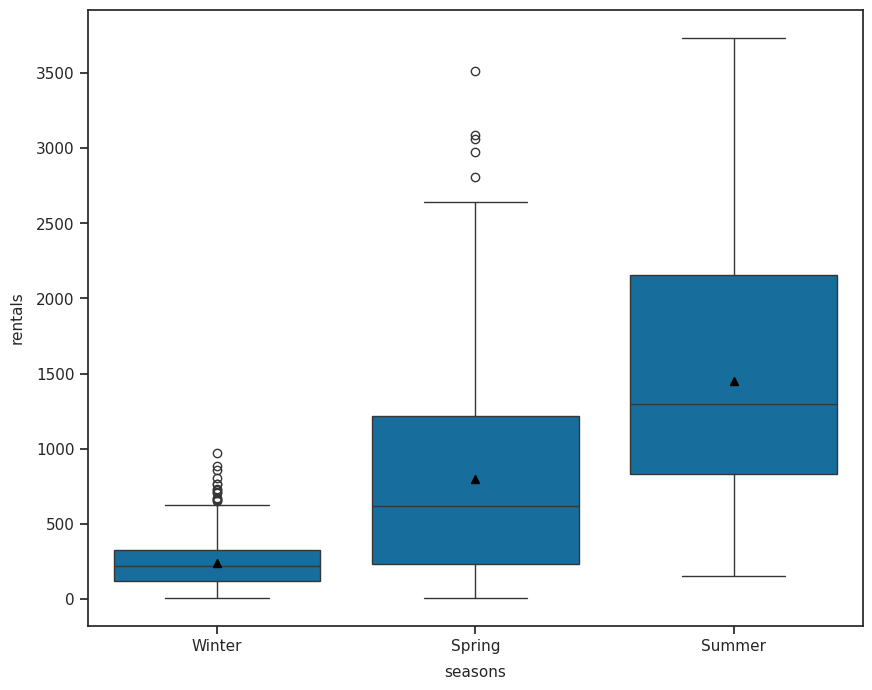

In [57]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'seasons',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

    plt.suptitle("")
    plt.show()

## Multicollinearity in weather variables

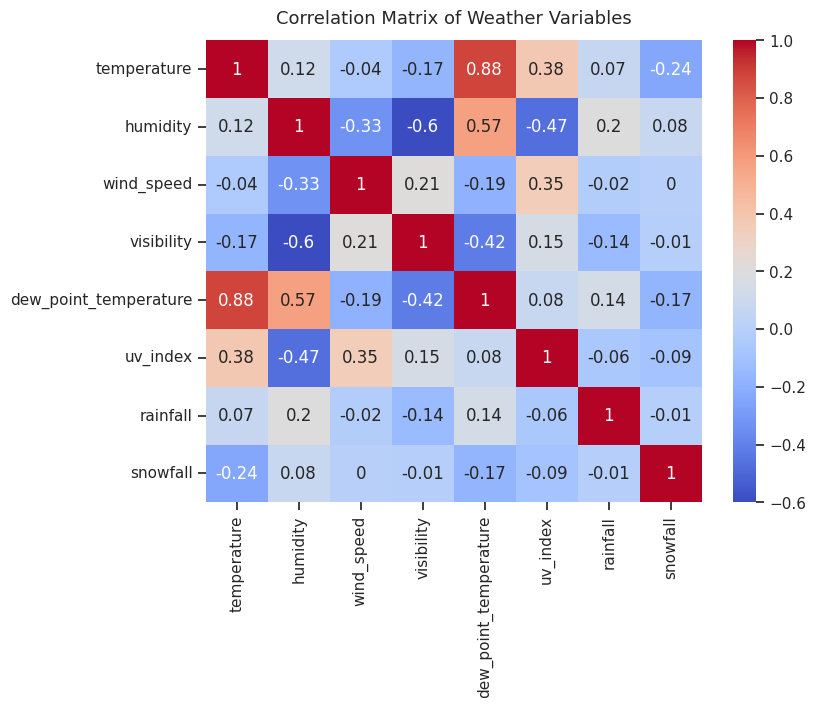

In [58]:
weather_vars = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall"
]
corr_matrix = bikerentals[weather_vars].corr().round(2)

fig, ax = plt.subplots()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm"
)

ax.set_title("Correlation Matrix of Weather Variables")

plt.show()



References:

Bergman, Z., Allenspach, N., & Bergman, M. M. (2024). A tale of two Divvys: The bicycle sharing system of Chicago. *Sustainability, 16*(5), 2146. https://doi.org/10.3390/su16052146

Yang, S., Brakewood, C., Nicolas, V., & Sion, J. (2019). Bikeshare users on a budget? Trip chaining analysis of bikeshare user groups in Chicago. *Transportation Research Record, 2673*(6), 1–12. https://doi.org/10.1177/0361198119838261